In [1]:
import info
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import warnings
import os.path
#import lightgbm as lgb
from utils import *
from backtest_algos import *

warnings.filterwarnings("ignore")

path_pc = 'C:/Users/admin/Desktop/AI Plan/Finance with AI/Notebooks/'
today = datetime.today()
print("Today's date:", today.strftime("%Y-%m-%d"))

Today's date: 2020-05-01


In [2]:
def ann_ret(ts):
    return np.power((ts[-1]/ts[0]),(252/len(ts)))-1

def ann_ret(ts):
    return np.power((ts[-1]/ts[0]),(252/len(ts)))-1

def dd(ts):
    return np.min(ts/np.maximum.accumulate(ts))-1

def performance(result, window):
    perf = result.copy()
    perf['daily_returns'] = perf['porfolio_value'].pct_change()
    rolling_window = result.porfolio_value.rolling(window)
    perf['annualized_return'] = rolling_window.apply(ann_ret)
    perf['annualized_volatility'] = perf.daily_returns.rolling(window).std()*np.sqrt(252)
    perf['sharpe_ratio'] = perf['annualized_return']/perf['annualized_volatility']
    perf['drawdown'] = rolling_window.apply(dd)
    perf['exposure'] = perf['positions_value']/500000
    return perf

In [3]:
versions = ['v63','v64','v65','v66','v67','v68']
lookback = 250
results = []
cols = []
for version in versions:
    result = pd.read_csv(path_pc+'LGB_v2_result_long_short_'+version+'_250.csv')
    result.drop(axis = 1, labels = 'Unnamed: 0', inplace = True)
    result = result.rename(columns={'porfolio_value':'porfolio_value_'+version})
    result['date'] = result['date'].astype('datetime64[ns]')
    result = result.set_index('date')
    cols.append('porfolio_value_'+version)
    results.append(result)

In [4]:
HSI = pd.read_csv(path_pc+'^HSI.csv')
HSI['Date'] = HSI['Date'].astype('datetime64[ns]')
HSI['date'] = HSI['Date']
HSI=HSI.set_index('date')

In [5]:
HSI=HSI.reindex(results[0].index)

In [6]:
combined = results[0].copy()
for i in range(1,len(results)):
    combined = combined.combine_first(results[i])

In [7]:
plot_data=combined.combine_first(HSI)
plot_data=plot_data.rename(columns={"Adj Close": "HSI"})
plot_data = plot_data[['HSI']+cols][-lookback:]

In [8]:
rebased_cols = []
for col in plot_data:
    plot_data[col+'_rebased']=(plot_data[col].pct_change()+1).cumprod()
    rebased_cols.append(col+'_rebased')
plot_data=plot_data[rebased_cols]

<IPython.core.display.Javascript object>


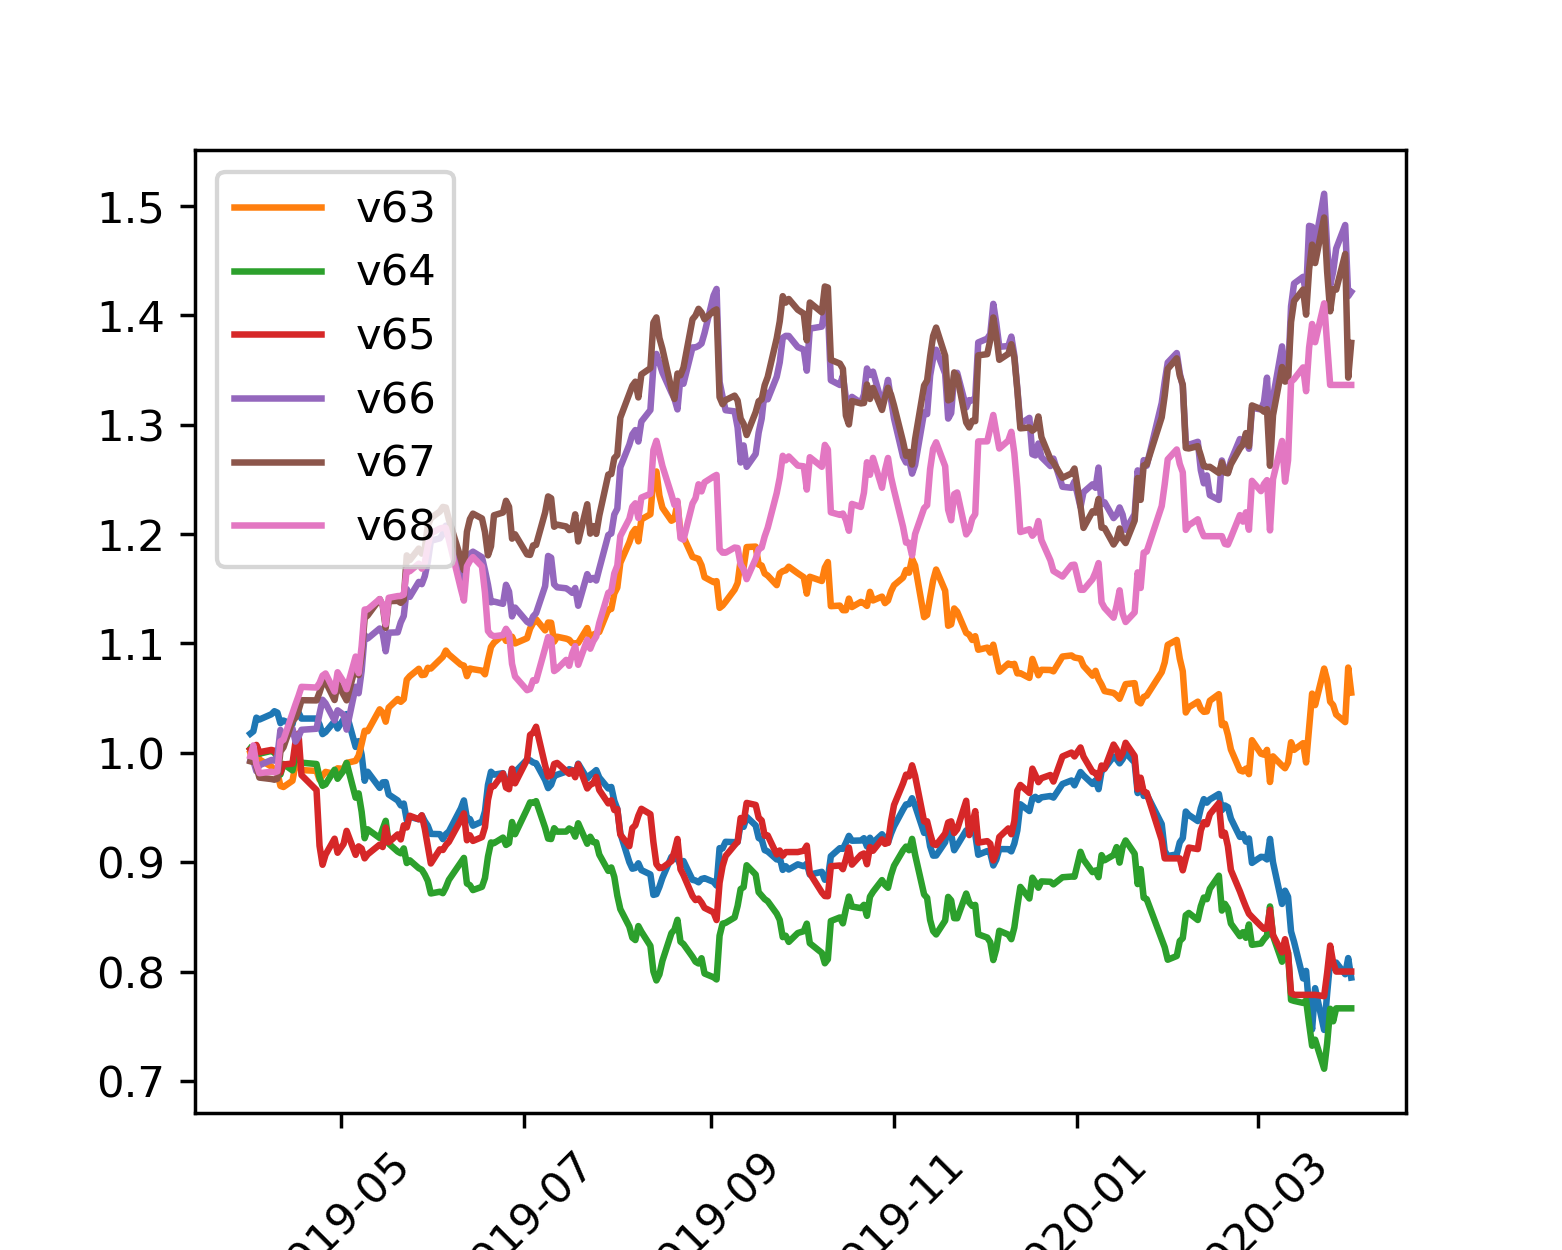

(array([737180., 737241., 737303., 737364., 737425., 737485.]),
 <a list of 6 Text xticklabel objects>)

In [9]:
%matplotlib notebook

fig = plt.figure(figsize = (5,4))

ax=fig.add_subplot(111)
for col in rebased_cols:
    ax.plot(plot_data[col], label=col[15:18])
ax.legend()
plt.xticks(rotation=45)

In [10]:
rebased_cols

['HSI_rebased',
 'porfolio_value_v63_rebased',
 'porfolio_value_v64_rebased',
 'porfolio_value_v65_rebased',
 'porfolio_value_v66_rebased',
 'porfolio_value_v67_rebased',
 'porfolio_value_v68_rebased']

In [11]:
for i in range(len(cols)):
    results[i]['porfolio_value'] = results[i][cols[i]]

In [12]:
perfs = []
window = 50
for result in results:
    perf = performance(result, window)
    perfs.append(perf)

In [13]:
sharpe_ratios = []
for perf in perfs:
    sharpe_ratio = (perf['daily_returns'].mean()*252)/(perf['daily_returns'].std()*np.sqrt(252))
    sharpe_ratios.append(sharpe_ratio)

In [14]:
print('Sharpe Ratios')
for i in range(len(versions)):
    print ('{}: {}'.format(versions[i],round(sharpe_ratios[i],2)))

Sharpe Ratios
v63: 0.4
v64: -1.02
v65: -0.87
v66: 1.52
v67: 1.35
v68: 1.29


In [15]:
print('Annual Returns')
for i in range(len(versions)):
    print ('{}: {}'.format(versions[i],round(ann_ret(results[i]['porfolio_value']),2)))

Annual Returns
v63: 0.06
v64: -0.24
v65: -0.2
v66: 0.43
v67: 0.38
v68: 0.34


In [16]:
print('Annualized Daily Volatility')
for i in range(len(versions)):
    print ('{}: {}'.format(versions[i],round(perfs[i]['daily_returns'].std()*16,2)))

Annualized Daily Volatility
v63: 0.18
v64: 0.24
v65: 0.23
v66: 0.26
v67: 0.27
v68: 0.25


In [17]:
print('Mean Windowed Max Drawdown')
for i in range(len(versions)):
    print ('{}: {}'.format(versions[i],round(perfs[i]['drawdown'].max(),3)))

Mean Windowed Max Drawdown
v63: -0.021
v64: -0.067
v65: -0.047
v66: -0.039
v67: -0.04
v68: -0.055
